# Solution {-}

Consider a two-dimensional problem where the position of an observer is moving in an oscillatory pattern. The position is to be determined by ranging measurements from two known references A and B.

The system can be described as an one dimensional PV-model along the x-axis.

In [1]:
from sympy import Matrix, diff, symbols, sqrt

# Symbols
xA, yA, xB, yB, x1, x2, x3, x4, r1, r2 = symbols('x_A y_A x_B y_B x1 x2 x3 x4 r1 r2')

# State vector
x = Matrix([[x1],
            [x2]])

# Measurement equation
r1 = sqrt((xA - x1)**2 + (yA - x3)**2)
r2 = sqrt((xB - x1)**2 + (yB - x3)**2)

# Design matrix (linearized)
H = Matrix([[r1],
            [r2]])
dH = H.jacobian(x)
display(dH)

Matrix([
[(x1 - x_A)/sqrt((-x1 + x_A)**2 + (-x3 + y_A)**2), 0],
[(x1 - x_B)/sqrt((-x1 + x_B)**2 + (-x3 + y_B)**2), 0]])

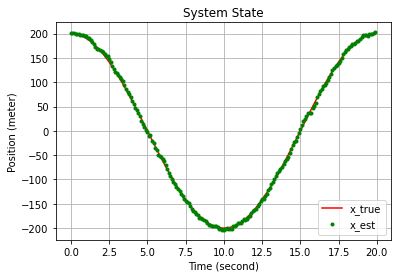

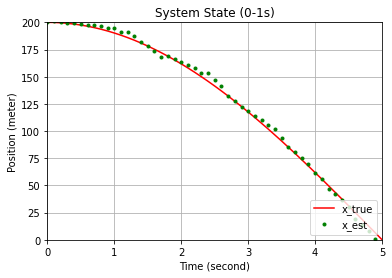

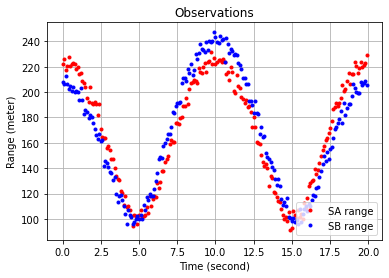

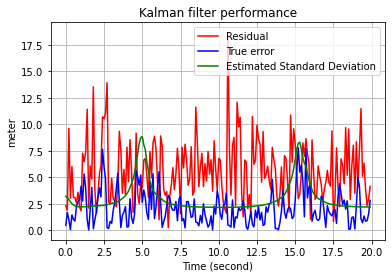

In [2]:
from numpy import arange, array, zeros, sqrt, pi, cos, eye, random, diag
from numpy.linalg import inv, norm
import matplotlib.pyplot as plt
from lib.vanloan import numeval

# System values
dt = 0.1        # [second]
qv = 400        # [m^2/s^3]
samples = 200   # number of samples
num = 3         # number of iterations (design matrix)

# Reference station coordinates
SA = array([[0],
            [100]])

SB = array([[20],
            [100]])

# Initial position
x = array([[200],
           [0]])

# Initial state covariance matrix
P = array([[200**2/2, 0],
           [0, 157**2/2]])

# Measurement covariance matrix
R = 4**2*eye(2)

# Dynamic matrix
F = array([[0, 1],
           [0, 0]])

# White noise coefficients
G = array([[0],
           [sqrt(qv)]])

# Numerical evaluation
[phi, Q] = numeval(F, G, dt)

# Linearized design matrix
def dH(x_nom):
    dH = zeros([2, 2])
    
    x0 = x_nom[0, 0]    # x - axis
    y0 = 0              # y - axis
    
    dxA = SA[0, 0] - x0
    dyA = SA[1, 0] - y0
    
    dxB = SB[0, 0] - x0
    dyB = SB[1, 0] - y0

    dH[0] = [-(dxA)/sqrt(dxA**2 + dyA**2), 0]
    dH[1] = [-(dxB)/sqrt(dxB**2 + dyB**2), 0]
    
    return dH

# Computed observations
def hx(x_nom):
    z0 = zeros([2, 1])
    
    x0 = x_nom[0, 0]
    y0 = 0
    
    dxA = SA[0, 0] - x0
    dyA = SA[1, 0] - y0
    
    dxB = SB[0, 0] - x0
    dyB = SB[1, 0] - y0
    
    z0[0] = [sqrt(dxA**2 + dyA**2)]
    z0[1] = [sqrt(dxB**2 + dyB**2)]
    
    return z0

# Plot vectors
x_all = []; P_all = []; xt_all =[]
z_all = []; zp_all = []

res = []; err = []

# Main loop
for i in range(0, samples):
    
    # True position
    xt = array([[200*cos(2*pi*i*dt/20)],
                [0]])
    
    # Noisy measurements
    z = hx(xt) + array([[random.normal(0, sqrt(R[0, 0]))],
                        [random.normal(0, sqrt(R[1, 1]))]])
    
    # Time update
    xp = phi@x
    Pp = phi@P@phi.T + Q
    
    for k in range(0, num):
        
        # Design matrix
        H = dH(x)
    
        # System size
        (n, e) = H.shape
        
        # Predicted observations
        zp = hx(xp)
    
        # Kalman gain
        K = Pp@H.T@inv(H@Pp@H.T + R)
    
        # Measurement update
        x = xp + K@(z - zp)
        P = (eye(e) - K@H)@Pp@(eye(e) - K@H).T + K@R@K.T
    
    # Accumulate plot vectors
    x_all.append(x)
    P_all.append(P)
    xt_all.append(xt)
    
    z_all.append(z)
    zp_all.append(zp)
    
    res.append(norm(z - zp))
    err.append(norm(xt[0] - x[0]))


# Generate plot vectors
pos_est = [x[0] for x in x_all]
pos_true = [xt[0] for xt in xt_all]
zSA = [z[0] for z in z_all]
zSB = [z[1] for z in z_all]

std = [sqrt(P[0, 0]) for P in P_all]

# Time
time = arange(0, samples)*dt


# Plotting position
plt.figure(1)
plt.plot(time, pos_true, 'r', label='x_true')
plt.plot(time, pos_est, 'g.', label='x_est')
plt.title('System State')
plt.xlabel('Time (second)')
plt.ylabel('Position (meter)')
plt.legend(loc='lower right')
plt.grid(True, which='both')
plt.show()

plt.figure(2)
plt.plot(time, pos_true, 'r', label='x_true')
plt.plot(time, pos_est, 'g.', label='x_est')
plt.title('System State (0-1s)')
plt.xlabel('Time (second)')
plt.ylabel('Position (meter)')
plt.xlim(0, 5)
plt.ylim(0, 200)
plt.legend(loc='lower right')
plt.grid(True, which='both')
plt.show()

plt.figure(3)
plt.plot(time, zSA, 'r.', label='SA range')
plt.plot(time, zSB, 'b.', label='SB range')
plt.title('Observations')
plt.xlabel('Time (second)')
plt.ylabel('Range (meter)')
plt.legend(loc='lower right')
plt.grid(True, which='both')
plt.show()

plt.figure(4)
plt.plot(time, res, 'r', label='Residual')
plt.plot(time, err, 'b', label='True error')
plt.plot(time, std, 'g', label='Estimated Standard Deviation')
plt.title('Kalman filter performance')
plt.xlabel('Time (second)')
plt.ylabel('meter')
plt.legend(loc='upper right')
plt.grid(True, which='both')
plt.show()